This notebook contains the first part of the implementation of the Euler-Bernoulli Beam using L2 error. In this notebook the number of hidden layers, the number of neurons per hidden layer and the learing rate are optimized with optuna. In the second notebook, the optimization will be finished and a final model will be trained. The second model also contains the calculation of velocity, acceleration and bending moment. \
Note that the AdamW optimizer is used. In an earlier step the optuna optimization also included the choice of optimizer. This is not included anymore because AdamW consistently led to the best results.

In [1]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import optuna
from optuna.trial import TrialState

torch.set_default_dtype(torch.float32)
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from cycler import cycler
import seaborn as sns

from urllib.request import urlretrieve

# Set the color scheme
sns.set_theme()
colors = [
    "#0076C2",
    "#EC6842",
    "#A50034",
    "#009B77",
    "#FFB81C",
    "#E03C31",
    "#6CC24A",
    "#EF60A3",
    "#0C2340",
    "#00B8C8",
    "#6F1D77",
]
plt.rcParams["axes.prop_cycle"] = cycler(color=colors)

In [2]:
def f_exact(x, t):
    return (1 - 16  * np.pi**2) * torch.sin(x) * torch.cos(4 * np.pi * t)

def u_exact(x, t):
    return torch.sin(x) * torch.cos(4 * np.pi * t)

In [3]:
def gen_data(L, t_end, n):
    x_vals = torch.rand(n) * L
    t_vals = torch.rand(n) * t_end
    return (x_vals, t_vals, f_exact(x_vals, t_vals), u_exact(x_vals, t_vals))

In [4]:
# training data generation
t_end = 1

x_gen, t_gen, f_gen, u_gen = gen_data(np.pi, t_end, 10000)
x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
# validation data generation
x_gen_val, t_gen_val, f_gen_val, u_gen_val = gen_data(np.pi, t_end, 1000)
x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)

C:\Users\danie\AppData\Local\Temp\ipykernel_13848\54349312.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen, t_gen, f_gen, u_gen = torch.tensor(x_gen, dtype=torch.float32), torch.tensor(t_gen, dtype=torch.float32), torch.tensor(f_gen, dtype=torch.float32), torch.tensor(u_gen, dtype=torch.float32)
C:\Users\danie\AppData\Local\Temp\ipykernel_13848\54349312.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_gen_val, t_gen_val, f_gen_val, u_gen_val = torch.tensor(x_gen_val, dtype=torch.float32), torch.tensor(t_gen_val, dtype=torch.float32), torch.tensor(f_gen_val, dtype=torch.float32), torch.tensor(u_gen_val, dtype=torch.float32)


In [5]:
# Class that normalizes data to follow Normal(0, 1) distribution.
class normUnitvar:
    def __init__(self, fullDataset):
        self.normmean = fullDataset.mean(axis=0)
        self.normstd = fullDataset.std(axis=0)

    def normalize(self, data):
        return (data - self.normmean) / self.normstd

    def denormalize(self, data):
        return data * self.normstd + self.normmean

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [7]:
# Create normalizers and normalize the data
x_normalizer = normUnitvar(x_gen)
t_normalizer = normUnitvar(t_gen)
f_normalizer = normUnitvar(f_gen)
u_normalizer = normUnitvar(u_gen)

x_norm = x_normalizer.normalize(x_gen)
t_norm = t_normalizer.normalize(t_gen)
f_norm = f_normalizer.normalize(f_gen)
u_norm = u_normalizer.normalize(u_gen)
# normalize validation data using the training normalizer
x_val_norm = x_normalizer.normalize(x_gen_val)
t_val_norm = t_normalizer.normalize(t_gen_val)
f_val_norm = f_normalizer.normalize(f_gen_val)
u_val_norm = u_normalizer.normalize(u_gen_val)

# Stack inputs (x, t, bias) and outputs (f, u) into N×3 and N×2 arrays
inputs_train_unnorm = torch.stack([x_gen, t_gen], dim=1).to(device)
outputs_train_unnorm = torch.stack([f_gen, u_gen], dim=1).to(device)
inputs_train = torch.stack([x_norm, t_norm], dim=1).to(device)  # Shape: [N, 3]
outputs_train = torch.stack([f_norm, u_norm], dim=1).to(device)  # Shape: [N, 2]
inputs_val = torch.stack([x_val_norm, t_val_norm], dim=1).to(device)  # Shape: [N_val, 3]
outputs_val = torch.stack([f_val_norm, u_val_norm], dim=1).to(device)  # Shape: [N_val, 2]

batch_size = 300
#training_dataset = torch.utils.data.TensorDataset(inputs_train, outputs_train)
validation_set = torch.utils.data.TensorDataset(inputs_val, outputs_val)

#train_loader = DataLoader(training_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_set, batch_size=batch_size)

# Model Definition

In [8]:
class MLP(nn.Module):
    "Defines a basic multi-layer perceptron."
    def __init__(self, input_size, hidden_size, output_size, num_hid_layers=4):
        super(MLP, self).__init__()
        # Define the layers of the network
        self.num_layers = num_hid_layers

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))

        for n in range(num_hid_layers):
            self.layers.append(nn.Linear(hidden_size, hidden_size))

        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, x, ):
        # Define the forward pass
        for i, layer in enumerate(self.layers):
            x = F.tanh(layer(x))  # Activation function (Tanh) after each layer
        x = self.fc_out(x)          # Output layer
        return x

In [9]:
# set the seed for reproducibility
torch.manual_seed(123)

# Define parameters
L = np.pi
T_end = 1

# Set sample sizes
N_f = 10000 # collocation points in interior
N_ic = 2000 # initial condition samples at t=0
N_bc = 2000 # boundary samples at x=0 and x=L

# setup to train the PINN
n_epochs = 200

# compute each term of the PINN loss function using the following hyperparameters (these were optimized with Optuna):
lambda_data = 0.7573
lambda_ic = 0.3492
lambda_bc = 0.2194
lambda_physics = 0.1221

# echo on screen
echo_every = 50

In [10]:
def evaluation(model, loader, loss_function):
    model.eval()  # specifies that the model is in evaluation mode
    losses = []

    # Remove gradients computations since we are only evaluating and not training
    with torch.no_grad():
        for batch in loader:
            # extract inputs x and outputs y from batch
            inputs, target = batch  # inputs: [batch_size, 2], target: [batch_size, 2]
            pred = model(inputs)
            # Extract only the u component from the target (second column) and unsqueeze to match pred shape
            target_u = target[:, 1].unsqueeze(1)
            loss = loss_function(pred, target_u)
            losses.append(loss.detach().item())

    return np.array(losses).mean()

In [11]:
def objective(trial):
    hidden_size = trial.suggest_int('hidden_size', 50, 500, step=50)
    learning_rate = trial.suggest_float('learning_rate', 5e-4, 1e-1, log=True)
    num_layers = trial.suggest_int('num_layers', 1, 4)

    pinn = MLP(2, hidden_size, 1, num_hid_layers=num_layers).to(device)
    optimiser = torch.optim.AdamW(pinn.parameters(), lr=learning_rate)

    max_trial_seconds = 120  # e.g., 2 minutes per trial

    start_time = time.perf_counter()


    for i in range(n_epochs+1):
        pinn.train()
        optimiser.zero_grad()

        # Resample all training points each iteration to avoid reusing graphs
        x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
        t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

        t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

        t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
        x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

        x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
        t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


        #compute data loss
        # Use the pre-stacked inputs_train for pinn input
        u_pred_data = pinn(inputs_train)
        # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
        target_u_norm = outputs_train[:, 1].unsqueeze(1)
        loss_data = torch.mean((u_pred_data - target_u_norm)**2)

        # initial condition
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_ic_1 = ((u - torch.sin(x_ic))**2).mean()
        dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
        loss_ic_2 = ((dudt - 0)**2).mean()

        # boundary condition left
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_left_1 = ((u - 0)**2).mean()
        dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
        loss_bc_left_2 = ((d2udx2_bc_left - 0)**2).mean()

        # boundary condition right
        u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
        u_denorm = u_normalizer.denormalize(u_norm)
        u = u_denorm
        loss_bc_right_1 = ((u - 0)**2).mean()
        dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
        d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
        loss_bc_right_2 = ((d2udx2_bc_right - 0)**2).mean()

        # compute physics loss
        EI = 1
        rhoA = 1
        u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
        u_f_denorm = u_normalizer.denormalize(u_f)
        u_f = u_f_denorm

        dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
        d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
        d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
        dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
        d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
        physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
        loss_physics = torch.mean(physics_residual**2)

        # backpropagate joint loss, take optimiser step
        loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
        loss.backward()
        optimiser.step()

        # validation loss
        validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())

        if i % (echo_every//5) == 0:
            intermediate_value = validation_loss
            trial.report(intermediate_value, i)

        # plot the result as training progresses (no grad tracking)
        if i % echo_every == 0:
            print(f"Epoch {i}: total loss = {loss}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data}, loss_ic_1 = {loss_ic_1}, loss_ic_2 = {loss_ic_2}, loss_bc_left_1 = {loss_bc_left_1}, loss_bc_left_2 = {loss_bc_left_2}, loss_bc_right_1 = {loss_bc_right_1}, loss_bc_right_2 = {loss_bc_right_2}, loss_physics = {loss_physics}")
            print(f"Validation loss at epoch {i}: {validation_loss:.6f}")

            if i!=0 and trial.should_prune():
                print(" (Pruned) Params: ")
                for key, value in trial.params.items():
                    print("    {}: {}".format(key, value))
                raise optuna.TrialPruned()

        # Check if the trial has exceeded the maximum allowed time
        elapsed = time.perf_counter() - start_time
        if elapsed > max_trial_seconds:
            # Stop *this* trial only
            raise optuna.exceptions.TrialPruned()


    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    return validation_loss


In [12]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# print("Best Hyperparameters:", study.best_params)

[I 2026-01-29 15:31:00,150] A new study created in memory with name: no-name-f8ad3130-83ae-4915-970a-364403f608bb


Epoch 0: total loss = 750.2862548828125, validation_loss = 3.680008, loss_data = 1.033456563949585, loss_ic_1 = 0.5261169075965881, loss_ic_2 = 0.008701164275407791, loss_bc_left_1 = 0.0034729510080069304, loss_bc_left_2 = 0.00026843391242437065, loss_bc_right_1 = 0.014461024664342403, loss_bc_right_2 = 0.00016184995183721185, loss_physics = 6136.8779296875
Validation loss at epoch 0: 3.680008
Epoch 50: total loss = 390.39666748046875, validation_loss = 0.987937, loss_data = 1.8525391817092896, loss_ic_1 = 0.6249838471412659, loss_ic_2 = 0.5583027601242065, loss_bc_left_1 = 0.24251504242420197, loss_bc_left_2 = 0.192610964179039, loss_bc_right_1 = 0.23012317717075348, loss_bc_right_2 = 0.8070513010025024, loss_physics = 3179.83203125
Validation loss at epoch 50: 0.987937
Epoch 100: total loss = 187.1229248046875, validation_loss = 6.863639, loss_data = 1.9436339139938354, loss_ic_1 = 0.31206998229026794, loss_ic_2 = 0.2692159116268158, loss_bc_left_1 = 0.3789432644844055, loss_bc_left_

[I 2026-01-29 15:31:21,978] Trial 0 finished with value: 0.6572534888982773 and parameters: {'hidden_size': 50, 'learning_rate': 0.08119424237042133, 'num_layers': 2}. Best is trial 0 with value: 0.6572534888982773.


Epoch 200: total loss = 34.07545852661133, validation_loss = 0.657253, loss_data = 0.5370498895645142, loss_ic_1 = 0.17248830199241638, loss_ic_2 = 3.3705196380615234, loss_bc_left_1 = 0.4684334397315979, loss_bc_left_2 = 0.49350008368492126, loss_bc_right_1 = 0.09142269939184189, loss_bc_right_2 = 0.27717652916908264, loss_physics = 263.22369384765625
Validation loss at epoch 200: 0.657253
  Params: 
    hidden_size: 50
    learning_rate: 0.08119424237042133
    num_layers: 2
Epoch 0: total loss = 760.2056274414062, validation_loss = 1.056872, loss_data = 1.0145819187164307, loss_ic_1 = 0.5503931045532227, loss_ic_2 = 0.0034974473528563976, loss_bc_left_1 = 0.012641816399991512, loss_bc_left_2 = 0.00018233683658763766, loss_bc_right_1 = 0.002146203303709626, loss_bc_right_2 = 0.00010016041051130742, loss_physics = 6218.18603515625
Validation loss at epoch 0: 1.056872
Epoch 50: total loss = 24.007041931152344, validation_loss = 1.213503, loss_data = 1.4468119144439697, loss_ic_1 = 0.51

[I 2026-01-29 15:31:36,175] Trial 1 finished with value: 0.05877551902085543 and parameters: {'hidden_size': 50, 'learning_rate': 0.007210782035576545, 'num_layers': 1}. Best is trial 1 with value: 0.05877551902085543.


Epoch 200: total loss = 0.8209714293479919, validation_loss = 0.058776, loss_data = 0.06520507484674454, loss_ic_1 = 0.01483836118131876, loss_ic_2 = 0.08161026239395142, loss_bc_left_1 = 0.09329546988010406, loss_bc_left_2 = 0.19248944520950317, loss_bc_right_1 = 0.042404577136039734, loss_bc_right_2 = 0.2386178970336914, loss_physics = 5.0250139236450195
Validation loss at epoch 200: 0.058776
  Params: 
    hidden_size: 50
    learning_rate: 0.007210782035576545
    num_layers: 1
Epoch 0: total loss = 749.574462890625, validation_loss = 3.849377, loss_data = 1.001100778579712, loss_ic_1 = 0.5143867135047913, loss_ic_2 = 0.0006505294004455209, loss_bc_left_1 = 0.000416526454500854, loss_bc_left_2 = 6.25421162112616e-05, loss_bc_right_1 = 0.0010685513261705637, loss_bc_right_2 = 4.667954272008501e-05, loss_physics = 6131.3359375
Validation loss at epoch 0: 3.849377


[I 2026-01-29 15:33:37,010] Trial 2 pruned. 


Epoch 0: total loss = 760.4338989257812, validation_loss = 1.050759, loss_data = 1.0152162313461304, loss_ic_1 = 0.5062362551689148, loss_ic_2 = 0.0072931828908622265, loss_bc_left_1 = 0.00461595831438899, loss_bc_left_2 = 5.6194625358330086e-05, loss_bc_right_1 = 0.0009342230041511357, loss_bc_right_2 = 0.0001861243654275313, loss_physics = 6220.18408203125
Validation loss at epoch 0: 1.050759
Epoch 50: total loss = 202.72286987304688, validation_loss = 1.699624, loss_data = 1.7946144342422485, loss_ic_1 = 3.24436092376709, loss_ic_2 = 0.33729323744773865, loss_bc_left_1 = 0.45064082741737366, loss_bc_left_2 = 0.02214154042303562, loss_bc_right_1 = 0.4417400658130646, loss_bc_right_2 = 0.016123106703162193, loss_physics = 1637.2554931640625
Validation loss at epoch 50: 1.699624
Epoch 100: total loss = 36.498443603515625, validation_loss = 5.904639, loss_data = 6.377202987670898, loss_ic_1 = 2.250037670135498, loss_ic_2 = 6.434786319732666, loss_bc_left_1 = 2.3433730602264404, loss_bc_

[I 2026-01-29 15:34:14,547] Trial 3 finished with value: 0.5411471202969551 and parameters: {'hidden_size': 100, 'learning_rate': 0.0012426169141918038, 'num_layers': 2}. Best is trial 1 with value: 0.05877551902085543.


Epoch 200: total loss = 4.6211652755737305, validation_loss = 0.541147, loss_data = 0.5986906290054321, loss_ic_1 = 0.21204282343387604, loss_ic_2 = 0.2148510217666626, loss_bc_left_1 = 0.28450459241867065, loss_bc_left_2 = 0.4102068841457367, loss_bc_right_1 = 0.4006155729293823, loss_bc_right_2 = 0.33356159925460815, loss_physics = 30.345680236816406
Validation loss at epoch 200: 0.541147
  Params: 
    hidden_size: 100
    learning_rate: 0.0012426169141918038
    num_layers: 2
Epoch 0: total loss = 756.0518188476562, validation_loss = 1.042991, loss_data = 1.004988670349121, loss_ic_1 = 0.574302613735199, loss_ic_2 = 5.308871186571196e-05, loss_bc_left_1 = 0.0018945878837257624, loss_bc_left_2 = 3.2358711905544624e-05, loss_bc_right_1 = 0.0028255395591259003, loss_bc_right_2 = 6.886642950121313e-05, loss_physics = 6184.18603515625
Validation loss at epoch 0: 1.042991
Epoch 50: total loss = 166.02174377441406, validation_loss = 6.097385, loss_data = 6.233194351196289, loss_ic_1 = 7.5

[I 2026-01-29 15:34:44,334] Trial 4 finished with value: 1.0759254693984985 and parameters: {'hidden_size': 50, 'learning_rate': 0.0027466080444833374, 'num_layers': 2}. Best is trial 1 with value: 0.05877551902085543.


Epoch 200: total loss = 12.971503257751465, validation_loss = 1.075925, loss_data = 1.1281285285949707, loss_ic_1 = 0.07666788250207901, loss_ic_2 = 6.340372562408447, loss_bc_left_1 = 0.5555205345153809, loss_bc_left_2 = 0.5019527673721313, loss_bc_right_1 = 0.4349426031112671, loss_bc_right_2 = 0.7299875020980835, loss_physics = 76.8938980102539
Validation loss at epoch 200: 1.075925
  Params: 
    hidden_size: 50
    learning_rate: 0.0027466080444833374
    num_layers: 2
Epoch 0: total loss = 753.7134399414062, validation_loss = 1.043177, loss_data = 1.002740740776062, loss_ic_1 = 0.5312613844871521, loss_ic_2 = 0.00042011041659861803, loss_bc_left_1 = 0.0018817087402567267, loss_bc_left_2 = 1.60233503265772e-05, loss_bc_right_1 = 0.0005530515336431563, loss_bc_right_2 = 1.0581099559203722e-05, loss_physics = 6165.1748046875
Validation loss at epoch 0: 1.043177
Epoch 50: total loss = 182.61270141601562, validation_loss = 13.076359, loss_data = 14.603217124938965, loss_ic_1 = 5.23654

[I 2026-01-29 15:36:16,924] Trial 5 finished with value: 2.2193708419799805 and parameters: {'hidden_size': 150, 'learning_rate': 0.0007442440825436285, 'num_layers': 4}. Best is trial 1 with value: 0.05877551902085543.


Epoch 200: total loss = 7.184843063354492, validation_loss = 2.219371, loss_data = 2.3059494495391846, loss_ic_1 = 1.9988877773284912, loss_ic_2 = 1.5880117416381836, loss_bc_left_1 = 1.0105091333389282, loss_bc_left_2 = 0.46246814727783203, loss_bc_right_1 = 1.0656887292861938, loss_bc_right_2 = 0.4825584888458252, loss_physics = 28.85458755493164
Validation loss at epoch 200: 2.219371
  Params: 
    hidden_size: 150
    learning_rate: 0.0007442440825436285
    num_layers: 4
Epoch 0: total loss = 754.2172241210938, validation_loss = 14.564498, loss_data = 1.0671491622924805, loss_ic_1 = 0.7853712439537048, loss_ic_2 = 0.004223136231303215, loss_bc_left_1 = 0.023882269859313965, loss_bc_left_2 = 9.727090946398675e-05, loss_bc_right_1 = 0.008697780780494213, loss_bc_right_2 = 0.00016958644846454263, loss_physics = 6168.109375
Validation loss at epoch 0: 14.564498
Epoch 50: total loss = 1.8350034952163696, validation_loss = 0.016467, loss_data = 0.02460462786257267, loss_ic_1 = 0.0225566

[I 2026-01-29 15:37:55,399] Trial 6 finished with value: 0.003184314409736544 and parameters: {'hidden_size': 450, 'learning_rate': 0.011786056450486323, 'num_layers': 1}. Best is trial 6 with value: 0.003184314409736544.


Epoch 200: total loss = 0.22759675979614258, validation_loss = 0.003184, loss_data = 0.003772795433178544, loss_ic_1 = 0.0011266417568549514, loss_ic_2 = 0.01110789179801941, loss_bc_left_1 = 0.005036689806729555, loss_bc_left_2 = 0.05542474612593651, loss_bc_right_1 = 0.0038031875155866146, loss_bc_right_2 = 0.02914215624332428, loss_physics = 1.6377876996994019
Validation loss at epoch 200: 0.003184
  Params: 
    hidden_size: 450
    learning_rate: 0.011786056450486323
    num_layers: 1
Epoch 0: total loss = 754.5802612304688, validation_loss = 31.078784, loss_data = 1.0054703950881958, loss_ic_1 = 0.45607686042785645, loss_ic_2 = 0.0018729034345597029, loss_bc_left_1 = 0.003519520629197359, loss_bc_left_2 = 5.698025051970035e-05, loss_bc_right_1 = 0.001253646332770586, loss_bc_right_2 = 0.0001674516242928803, loss_physics = 6172.46337890625
Validation loss at epoch 0: 31.078784
Epoch 50: total loss = 471.5948181152344, validation_loss = 0.567756, loss_data = 0.3867532014846802, los

[I 2026-01-29 15:39:37,533] Trial 7 finished with value: 0.1274349559098482 and parameters: {'hidden_size': 500, 'learning_rate': 0.031414829708270677, 'num_layers': 1}. Best is trial 6 with value: 0.003184314409736544.


Epoch 200: total loss = 69.67192077636719, validation_loss = 0.127435, loss_data = 0.16840600967407227, loss_ic_1 = 0.2773885726928711, loss_ic_2 = 5.990488052368164, loss_bc_left_1 = 0.09681599587202072, loss_bc_left_2 = 0.16382767260074615, loss_bc_right_1 = 0.1193898394703865, loss_bc_right_2 = 0.07654867321252823, loss_physics = 550.8228149414062
Validation loss at epoch 200: 0.127435
  Params: 
    hidden_size: 500
    learning_rate: 0.031414829708270677
    num_layers: 1
Epoch 0: total loss = 752.271728515625, validation_loss = 1.049585, loss_data = 1.0016793012619019, loss_ic_1 = 0.5169532895088196, loss_ic_2 = 0.0008664003107696772, loss_bc_left_1 = 0.0006921510794200003, loss_bc_left_2 = 3.97003059333656e-05, loss_bc_right_1 = 0.000361891754437238, loss_bc_right_2 = 0.00010450580884935334, loss_physics = 6153.416015625
Validation loss at epoch 0: 1.049585
Epoch 50: total loss = 11.563169479370117, validation_loss = 2.172176, loss_data = 2.228008508682251, loss_ic_1 = 0.2004205

[I 2026-01-29 15:41:36,384] Trial 8 finished with value: 0.03524704556912184 and parameters: {'hidden_size': 200, 'learning_rate': 0.0029359253154899547, 'num_layers': 3}. Best is trial 6 with value: 0.003184314409736544.


Epoch 200: total loss = 0.3027834892272949, validation_loss = 0.035247, loss_data = 0.03931782767176628, loss_ic_1 = 0.0018343260744586587, loss_ic_2 = 0.02978472039103508, loss_bc_left_1 = 0.05163023620843887, loss_bc_left_2 = 0.10522401332855225, loss_bc_right_1 = 0.05090808868408203, loss_bc_right_2 = 0.11441962420940399, loss_physics = 1.5665847063064575
Validation loss at epoch 200: 0.035247
  Params: 
    hidden_size: 200
    learning_rate: 0.0029359253154899547
    num_layers: 3
Epoch 0: total loss = 751.6801147460938, validation_loss = 1.063540, loss_data = 1.0070418119430542, loss_ic_1 = 0.44209587574005127, loss_ic_2 = 0.002304408000782132, loss_bc_left_1 = 0.001137912622652948, loss_bc_left_2 = 0.0001575165515532717, loss_bc_right_1 = 0.00501298950985074, loss_bc_right_2 = 0.0002701092162169516, loss_physics = 6148.7373046875
Validation loss at epoch 0: 1.063540
Epoch 50: total loss = 30.20253562927246, validation_loss = 4.482391, loss_data = 5.233091354370117, loss_ic_1 = 1

[I 2026-01-29 15:42:53,716] Trial 9 finished with value: 0.03859552089124918 and parameters: {'hidden_size': 200, 'learning_rate': 0.0018739326089909272, 'num_layers': 2}. Best is trial 6 with value: 0.003184314409736544.


Epoch 200: total loss = 0.3600621819496155, validation_loss = 0.038596, loss_data = 0.04709991440176964, loss_ic_1 = 0.019022276625037193, loss_ic_2 = 0.10698135942220688, loss_bc_left_1 = 0.02979547157883644, loss_bc_left_2 = 0.14305844902992249, loss_bc_right_1 = 0.07157561182975769, loss_bc_right_2 = 0.18850794434547424, loss_physics = 1.518480658531189
Validation loss at epoch 200: 0.038596
  Params: 
    hidden_size: 200
    learning_rate: 0.0018739326089909272
    num_layers: 2
Epoch 0: total loss = 761.9306640625, validation_loss = 3.366245, loss_data = 1.023362636566162, loss_ic_1 = 0.7198869585990906, loss_ic_2 = 0.014680998399853706, loss_bc_left_1 = 0.006680894177407026, loss_bc_left_2 = 0.0002776363689918071, loss_bc_right_1 = 0.004063970874994993, loss_bc_right_2 = 0.00014245836064219475, loss_physics = 6231.75048828125
Validation loss at epoch 0: 3.366245
Epoch 50: total loss = 1.6125428676605225, validation_loss = 0.012183, loss_data = 0.015257570892572403, loss_ic_1 = 0

[I 2026-01-29 15:44:00,750] Trial 10 finished with value: 0.002935173164587468 and parameters: {'hidden_size': 350, 'learning_rate': 0.009735601152834955, 'num_layers': 1}. Best is trial 10 with value: 0.002935173164587468.


Epoch 200: total loss = 0.7813165783882141, validation_loss = 0.002935, loss_data = 0.0036196266300976276, loss_ic_1 = 0.00047805460053496063, loss_ic_2 = 0.0037428319919854403, loss_bc_left_1 = 0.004372062627226114, loss_bc_left_2 = 0.03302427753806114, loss_bc_right_1 = 0.003416580380871892, loss_bc_right_2 = 0.029861507937312126, loss_physics = 6.237473487854004
Validation loss at epoch 200: 0.002935
  Params: 
    hidden_size: 350
    learning_rate: 0.009735601152834955
    num_layers: 1
Epoch 0: total loss = 749.2518920898438, validation_loss = 6.476539, loss_data = 1.0088180303573608, loss_ic_1 = 0.5509552359580994, loss_ic_2 = 0.010881944559514523, loss_bc_left_1 = 0.005086250137537718, loss_bc_left_2 = 0.00045840037637390196, loss_bc_right_1 = 0.006316286511719227, loss_bc_right_2 = 4.639532562578097e-05, loss_physics = 6128.494140625
Validation loss at epoch 0: 6.476539
Epoch 50: total loss = 1.606869101524353, validation_loss = 0.028754, loss_data = 0.03593040630221367, loss_

[I 2026-01-29 15:45:08,128] Trial 11 finished with value: 0.0020959443354513496 and parameters: {'hidden_size': 350, 'learning_rate': 0.00900313437515103, 'num_layers': 1}. Best is trial 11 with value: 0.0020959443354513496.


Epoch 200: total loss = 0.1448022425174713, validation_loss = 0.002096, loss_data = 0.0022804855834692717, loss_ic_1 = 0.0009070184896700084, loss_ic_2 = 0.0048292046412825584, loss_bc_left_1 = 0.004055526107549667, loss_bc_left_2 = 0.03630783408880234, loss_bc_right_1 = 0.0019396216375753284, loss_bc_right_2 = 0.026783596724271774, loss_physics = 1.0312411785125732
Validation loss at epoch 200: 0.002096
  Params: 
    hidden_size: 350
    learning_rate: 0.00900313437515103
    num_layers: 1
Epoch 0: total loss = 747.7979736328125, validation_loss = 4.991999, loss_data = 1.0799579620361328, loss_ic_1 = 0.33345404267311096, loss_ic_2 = 0.06370218843221664, loss_bc_left_1 = 0.04232945293188095, loss_bc_left_2 = 0.002365298103541136, loss_bc_right_1 = 0.034903254359960556, loss_bc_right_2 = 0.0029262967873364687, loss_physics = 6116.48876953125
Validation loss at epoch 0: 4.991999
Epoch 50: total loss = 2.314321994781494, validation_loss = 0.056923, loss_data = 0.0757746770977974, loss_ic

[I 2026-01-29 15:46:15,700] Trial 12 finished with value: 0.0065326152835041285 and parameters: {'hidden_size': 350, 'learning_rate': 0.006185721635634266, 'num_layers': 1}. Best is trial 11 with value: 0.0020959443354513496.


Epoch 200: total loss = 0.3046054542064667, validation_loss = 0.006533, loss_data = 0.0064315772615373135, loss_ic_1 = 0.0016811857931315899, loss_ic_2 = 0.08201585710048676, loss_bc_left_1 = 0.009959850460290909, loss_bc_left_2 = 0.021330058574676514, loss_bc_right_1 = 0.006904829293489456, loss_bc_right_2 = 0.03507988527417183, loss_physics = 2.0837948322296143
Validation loss at epoch 200: 0.006533
  Params: 
    hidden_size: 350
    learning_rate: 0.006185721635634266
    num_layers: 1
Epoch 0: total loss = 761.1624755859375, validation_loss = 4.604032, loss_data = 1.0048272609710693, loss_ic_1 = 0.4615544080734253, loss_ic_2 = 0.00011069430911447853, loss_bc_left_1 = 0.0008977102697826922, loss_bc_left_2 = 0.00012704837718047202, loss_bc_right_1 = 0.0011879628291353583, loss_bc_right_2 = 9.303449769504368e-05, loss_physics = 6226.3701171875
Validation loss at epoch 0: 4.604032


[I 2026-01-29 15:48:18,672] Trial 13 pruned. 


Epoch 0: total loss = 748.223876953125, validation_loss = 2.618347, loss_data = 1.0008862018585205, loss_ic_1 = 0.4634626805782318, loss_ic_2 = 0.007465440314263105, loss_bc_left_1 = 0.00040877415449358523, loss_bc_left_2 = 3.600923082558438e-05, loss_bc_right_1 = 0.00042108347406610847, loss_bc_right_2 = 9.944665362127125e-05, loss_physics = 6120.4033203125
Validation loss at epoch 0: 2.618347
Epoch 50: total loss = 776.864013671875, validation_loss = 1.414939, loss_data = 1.5965046882629395, loss_ic_1 = 0.3806963562965393, loss_ic_2 = 0.05315866693854332, loss_bc_left_1 = 0.11762040108442307, loss_bc_left_2 = 0.0483817458152771, loss_bc_right_1 = 0.17369496822357178, loss_bc_right_2 = 0.03270694613456726, loss_physics = 6350.71044921875
Validation loss at epoch 50: 1.414939


[I 2026-01-29 15:48:52,552] Trial 14 pruned. 


Epoch 100: total loss = 763.017578125, validation_loss = 1.202463, loss_data = 1.1144707202911377, loss_ic_1 = 0.32436415553092957, loss_ic_2 = 0.0010993365431204438, loss_bc_left_1 = 0.026766687631607056, loss_bc_left_2 = 0.00011817314953077585, loss_bc_right_1 = 0.02585395611822605, loss_bc_right_2 = 5.921783508000544e-09, loss_physics = 6241.18212890625
Validation loss at epoch 100: 1.202463
 (Pruned) Params: 
    hidden_size: 350
    learning_rate: 0.05175336142260786
    num_layers: 1
Epoch 0: total loss = 753.4529418945312, validation_loss = 6.364882, loss_data = 1.0255271196365356, loss_ic_1 = 0.5153935551643372, loss_ic_2 = 0.01579182595014572, loss_bc_left_1 = 0.0051280539482831955, loss_bc_left_2 = 0.0003421288856770843, loss_bc_right_1 = 0.002210022183135152, loss_bc_right_2 = 8.167951455106959e-05, loss_physics = 6162.89208984375
Validation loss at epoch 0: 6.364882
Epoch 50: total loss = 3.236081123352051, validation_loss = 0.158243, loss_data = 0.1730147898197174, loss_ic

[I 2026-01-29 15:49:47,520] Trial 15 finished with value: 0.005008424515835941 and parameters: {'hidden_size': 300, 'learning_rate': 0.0068966754554015824, 'num_layers': 1}. Best is trial 11 with value: 0.0020959443354513496.


Epoch 200: total loss = 0.10676859319210052, validation_loss = 0.005008, loss_data = 0.0058192964643239975, loss_ic_1 = 0.005267719738185406, loss_ic_2 = 0.010972618125379086, loss_bc_left_1 = 0.008600023575127125, loss_bc_left_2 = 0.061148956418037415, loss_bc_right_1 = 0.005494810175150633, loss_bc_right_2 = 0.04970324784517288, loss_physics = 0.5673802495002747
Validation loss at epoch 200: 0.005008
  Params: 
    hidden_size: 300
    learning_rate: 0.0068966754554015824
    num_layers: 1
Epoch 0: total loss = 741.1641235351562, validation_loss = 6.803745, loss_data = 1.0015767812728882, loss_ic_1 = 0.48157283663749695, loss_ic_2 = 0.0005551300127990544, loss_bc_left_1 = 0.0016949017299339175, loss_bc_left_2 = 0.00014353040023706853, loss_bc_right_1 = 0.0009259784710593522, loss_bc_right_2 = 0.00013454911822918802, loss_physics = 6062.5439453125
Validation loss at epoch 0: 6.803745


[I 2026-01-29 15:51:48,222] Trial 16 pruned. 


Epoch 0: total loss = 748.640380859375, validation_loss = 1.458368, loss_data = 1.0019220113754272, loss_ic_1 = 0.49447712302207947, loss_ic_2 = 0.0019723777659237385, loss_bc_left_1 = 0.0025315661914646626, loss_bc_left_2 = 0.0002551385259721428, loss_bc_right_1 = 0.00039034095243550837, loss_bc_right_2 = 5.9382171457400545e-05, loss_physics = 6123.73095703125
Validation loss at epoch 0: 1.458368


[I 2026-01-29 15:52:12,168] Trial 17 pruned. 


Epoch 50: total loss = 8.8027982711792, validation_loss = 1.135693, loss_data = 1.3834173679351807, loss_ic_1 = 1.0020090341567993, loss_ic_2 = 0.8474667072296143, loss_bc_left_1 = 0.2938942611217499, loss_bc_left_2 = 0.2251717895269394, loss_bc_right_1 = 0.34114986658096313, loss_bc_right_2 = 0.22203907370567322, loss_physics = 56.2805290222168
Validation loss at epoch 50: 1.135693
 (Pruned) Params: 
    hidden_size: 250
    learning_rate: 0.004325737290328371
    num_layers: 2
Epoch 0: total loss = 757.9423217773438, validation_loss = 32.690528, loss_data = 1.0307403802871704, loss_ic_1 = 0.48008352518081665, loss_ic_2 = 0.02440711483359337, loss_bc_left_1 = 0.004476336762309074, loss_bc_left_2 = 0.0005247752997092903, loss_bc_right_1 = 0.00542649207636714, loss_bc_right_2 = 8.605103357695043e-05, loss_physics = 6199.69921875
Validation loss at epoch 0: 32.690528
Epoch 50: total loss = 276.1303405761719, validation_loss = 1.187685, loss_data = 1.0897033214569092, loss_ic_1 = 0.554533

[I 2026-01-29 15:52:56,071] Trial 18 pruned. 


Epoch 100: total loss = 79.397216796875, validation_loss = 0.781669, loss_data = 0.4671269357204437, loss_ic_1 = 0.2540724575519562, loss_ic_2 = 0.9496251940727234, loss_bc_left_1 = 0.14634855091571808, loss_bc_left_2 = 0.23214711248874664, loss_bc_right_1 = 0.2140984833240509, loss_bc_right_2 = 0.28839436173439026, loss_physics = 642.3410034179688
Validation loss at epoch 100: 0.781669
 (Pruned) Params: 
    hidden_size: 400
    learning_rate: 0.03446639720001541
    num_layers: 1
Epoch 0: total loss = 753.509521484375, validation_loss = 8.861701, loss_data = 1.0170782804489136, loss_ic_1 = 0.6649028062820435, loss_ic_2 = 0.010025161318480968, loss_bc_left_1 = 0.009660066105425358, loss_bc_left_2 = 0.00015931684174574912, loss_bc_right_1 = 0.0017352720024064183, loss_bc_right_2 = 0.00011432425526436418, loss_physics = 6162.9892578125
Validation loss at epoch 0: 8.861701
Epoch 50: total loss = 42.14540481567383, validation_loss = 0.161416, loss_data = 0.1965245008468628, loss_ic_1 = 0.

[I 2026-01-29 15:54:17,830] Trial 19 finished with value: 0.0293431025929749 and parameters: {'hidden_size': 250, 'learning_rate': 0.013209472574850795, 'num_layers': 2}. Best is trial 11 with value: 0.0020959443354513496.


Epoch 200: total loss = 0.5374494791030884, validation_loss = 0.029343, loss_data = 0.020345909520983696, loss_ic_1 = 0.012183133512735367, loss_ic_2 = 0.01807144284248352, loss_bc_left_1 = 0.023030953481793404, loss_bc_left_2 = 0.030400050804018974, loss_bc_right_1 = 0.02582988142967224, loss_bc_right_2 = 0.06877037137746811, loss_physics = 3.923001766204834
Validation loss at epoch 200: 0.029343
  Params: 
    hidden_size: 250
    learning_rate: 0.013209472574850795
    num_layers: 2
Epoch 0: total loss = 769.310302734375, validation_loss = 1.663335, loss_data = 1.0030393600463867, loss_ic_1 = 0.5498993992805481, loss_ic_2 = 0.00316567812114954, loss_bc_left_1 = 0.0002874629572033882, loss_bc_left_2 = 0.00014257861766964197, loss_bc_right_1 = 0.004611663054674864, loss_bc_right_2 = 0.000179563881829381, loss_physics = 6292.84521484375
Validation loss at epoch 0: 1.663335
Epoch 50: total loss = 1.4720324277877808, validation_loss = 0.044050, loss_data = 0.05304685980081558, loss_ic_1 

[I 2026-01-29 15:55:12,389] Trial 20 finished with value: 0.00318566506030038 and parameters: {'hidden_size': 300, 'learning_rate': 0.0044598073459423205, 'num_layers': 1}. Best is trial 11 with value: 0.0020959443354513496.


Epoch 200: total loss = 0.9488627314567566, validation_loss = 0.003186, loss_data = 0.0035962199326604605, loss_ic_1 = 0.0006168546387925744, loss_ic_2 = 0.06976331770420074, loss_bc_left_1 = 0.005576972849667072, loss_bc_left_2 = 0.043216388672590256, loss_bc_right_1 = 0.004233967512845993, loss_bc_right_2 = 0.05484481155872345, loss_physics = 7.3537702560424805
Validation loss at epoch 200: 0.003186
  Params: 
    hidden_size: 300
    learning_rate: 0.0044598073459423205
    num_layers: 1
Epoch 0: total loss = 757.9962768554688, validation_loss = 15.622250, loss_data = 1.053070068359375, loss_ic_1 = 0.4303067624568939, loss_ic_2 = 0.012696041725575924, loss_bc_left_1 = 0.0018094185506924987, loss_bc_left_2 = 0.0012048253556713462, loss_bc_right_1 = 0.022371217608451843, loss_bc_right_2 = 0.0008488846360705793, loss_physics = 6200.14990234375
Validation loss at epoch 0: 15.622250
Epoch 50: total loss = 2.9952352046966553, validation_loss = 0.022371, loss_data = 0.028426341712474823, l

[I 2026-01-29 15:56:48,613] Trial 21 finished with value: 0.0008644967019790784 and parameters: {'hidden_size': 450, 'learning_rate': 0.011430095161745986, 'num_layers': 1}. Best is trial 21 with value: 0.0008644967019790784.


Epoch 200: total loss = 0.11836602538824081, validation_loss = 0.000864, loss_data = 0.0009463090682402253, loss_ic_1 = 0.0003215617034584284, loss_ic_2 = 0.00633788900449872, loss_bc_left_1 = 0.0027518796268850565, loss_bc_left_2 = 0.05288155749440193, loss_bc_right_1 = 0.0013438095338642597, loss_bc_right_2 = 0.060867790132761, loss_physics = 0.7327494025230408
Validation loss at epoch 200: 0.000864
  Params: 
    hidden_size: 450
    learning_rate: 0.011430095161745986
    num_layers: 1
Epoch 0: total loss = 747.9884033203125, validation_loss = 8.237325, loss_data = 1.0056321620941162, loss_ic_1 = 0.42910000681877136, loss_ic_2 = 0.0036058747209608555, loss_bc_left_1 = 0.0012321971589699388, loss_bc_left_2 = 2.8527798349387012e-05, loss_bc_right_1 = 0.0016456878511235118, loss_bc_right_2 = 6.010627112118527e-05, loss_physics = 6118.55078125
Validation loss at epoch 0: 8.237325
Epoch 50: total loss = 1.886088252067566, validation_loss = 0.029147, loss_data = 0.034127552062273026, los

[I 2026-01-29 15:58:28,843] Trial 22 finished with value: 0.002219338552094996 and parameters: {'hidden_size': 450, 'learning_rate': 0.009270458050717299, 'num_layers': 1}. Best is trial 21 with value: 0.0008644967019790784.


Epoch 200: total loss = 0.11099936068058014, validation_loss = 0.002219, loss_data = 0.0023697440046817064, loss_ic_1 = 0.0012390834745019674, loss_ic_2 = 0.01687745563685894, loss_bc_left_1 = 0.0035722972825169563, loss_bc_left_2 = 0.04258125647902489, loss_bc_right_1 = 0.0026317466981709003, loss_bc_right_2 = 0.04320713132619858, loss_physics = 0.6772753000259399
Validation loss at epoch 200: 0.002219
  Params: 
    hidden_size: 450
    learning_rate: 0.009270458050717299
    num_layers: 1
Epoch 0: total loss = 740.5752563476562, validation_loss = 11.366361, loss_data = 1.0427173376083374, loss_ic_1 = 0.5499399900436401, loss_ic_2 = 0.03585446625947952, loss_bc_left_1 = 0.0011860242811962962, loss_bc_left_2 = 0.00024112580285873264, loss_bc_right_1 = 0.032580625265836716, loss_bc_right_2 = 0.00030776276253163815, loss_physics = 6057.11328125
Validation loss at epoch 0: 11.366361
Epoch 50: total loss = 23.10003662109375, validation_loss = 0.707003, loss_data = 0.8018922209739685, loss

[I 2026-01-29 15:59:42,627] Trial 23 pruned. 


Epoch 150: total loss = 2.9449448585510254, validation_loss = 0.090556, loss_data = 0.09644822776317596, loss_ic_1 = 0.046698197722435, loss_ic_2 = 0.14931918680667877, loss_bc_left_1 = 0.016975970938801765, loss_bc_left_2 = 0.054858796298503876, loss_bc_right_1 = 0.0631319060921669, loss_bc_right_2 = 0.06270084530115128, loss_physics = 22.605134963989258
Validation loss at epoch 150: 0.090556
 (Pruned) Params: 
    hidden_size: 450
    learning_rate: 0.01857297054146266
    num_layers: 1
Epoch 0: total loss = 764.9468994140625, validation_loss = 6.005144, loss_data = 1.014701008796692, loss_ic_1 = 0.4606151282787323, loss_ic_2 = 0.007655745837837458, loss_bc_left_1 = 0.0025896341539919376, loss_bc_left_2 = 5.9357214922783896e-05, loss_bc_right_1 = 0.0014562312280759215, loss_bc_right_2 = 2.876767212001141e-05, loss_physics = 6257.28125
Validation loss at epoch 0: 6.005144
Epoch 50: total loss = 1.790928840637207, validation_loss = 0.044077, loss_data = 0.05516079440712929, loss_ic_1 =

[I 2026-01-29 16:01:43,324] Trial 24 pruned. 


Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  8
  Number of complete trials:  17
Best trial:
  Value:  0.0008644967019790784
  Params: 
    hidden_size: 450
    learning_rate: 0.011430095161745986
    num_layers: 1


In [13]:
print("Best Hyperparameters:", study.best_params)

Best Hyperparameters: {'hidden_size': 450, 'learning_rate': 0.011430095161745986, 'num_layers': 1}


## Useful optuna plots

In [14]:
optuna.visualization.plot_param_importances(study)

In [15]:
optuna.visualization.plot_parallel_coordinate(study)

In [16]:
fig = optuna.visualization.plot_intermediate_values(study)

# Fix the visible y-range
fig.update_yaxes(range=[0.0, 10])

In [17]:
# train the model with the best hyperparameters
best_params = study.best_params

# Create a new model with the best parameters
pinn = MLP(2, best_params['hidden_size'], 1, num_hid_layers=best_params['num_layers']).to(device)
optimiser = torch.optim.Adam(pinn.parameters(), lr=best_params['learning_rate'])

n_epochs = 200

best_loss = float('inf')
min_delta = 1e-6


for i in range(n_epochs+1):
    pinn.train()
    optimiser.zero_grad()

    # Resample all training points each iteration to avoid reusing graphs
    x_ic = (L * torch.rand(N_ic, 1, requires_grad=True)).to(device)
    t_ic = torch.zeros_like(x_ic, requires_grad=True).to(device)

    t_bc_left = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_left = torch.zeros_like(t_bc_left, requires_grad=True).to(device)

    t_bc_right = (T_end * torch.rand(N_bc, 1, requires_grad=True)).to(device)
    x_bc_right = (L * torch.ones_like(t_bc_right, requires_grad=True)).to(device)

    x_f = (L * torch.rand(N_f, 1, requires_grad=True)).to(device)
    t_f = (T_end * torch.rand(N_f, 1, requires_grad=True)).to(device)


    #compute data loss
    # Use the pre-stacked inputs_train for pinn input
    u_pred_data = pinn(inputs_train)
    # The true u_norm is the second column of outputs_train; unsqueeze to match pinn's output shape (N,1)
    target_u_norm = outputs_train[:, 1].unsqueeze(1)
    loss_data = torch.mean((u_pred_data - target_u_norm)**2)

    # initial condition
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_ic), t_normalizer.normalize(t_ic)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_ic_1 = ((u - torch.sin(x_ic))**2).mean()
    dudt = torch.autograd.grad(u, t_ic, torch.ones_like(u), create_graph=True)[0]
    loss_ic_2 = ((dudt - 0)**2).mean()

    # boundary condition left
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_left), t_normalizer.normalize(t_bc_left)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_left_1 = ((u - 0)**2).mean()
    dudx_bc_left = torch.autograd.grad(u, x_bc_left, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_left = torch.autograd.grad(dudx_bc_left, x_bc_left, torch.ones_like(dudx_bc_left), create_graph=True)[0]
    loss_bc_left_2 = ((d2udx2_bc_left - 0)**2).mean()

    # boundary condition right
    u_norm = pinn(torch.cat([x_normalizer.normalize(x_bc_right), t_normalizer.normalize(t_bc_right)], dim=1))
    u_denorm = u_normalizer.denormalize(u_norm)
    u = u_denorm
    loss_bc_right_1 = ((u - 0)**2).mean()
    dudx_bc_right = torch.autograd.grad(u, x_bc_right, torch.ones_like(u), create_graph=True)[0]
    d2udx2_bc_right = torch.autograd.grad(dudx_bc_right, x_bc_right, torch.ones_like(dudx_bc_right), create_graph=True)[0]
    loss_bc_right_2 = ((d2udx2_bc_right - 0)**2).mean()

    # compute physics loss
    EI = 1
    rhoA = 1
    u_f = pinn(torch.cat([x_normalizer.normalize(x_f), t_normalizer.normalize(t_f)], dim=1))
    u_f_denorm = u_normalizer.denormalize(u_f)
    u_f = u_f_denorm

    dudx_f = torch.autograd.grad(u_f, x_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udx2_f = torch.autograd.grad(dudx_f, x_f, torch.ones_like(dudx_f), create_graph=True)[0]
    d3udx3_f = torch.autograd.grad(d2udx2_f, x_f, torch.ones_like(d2udx2_f), create_graph=True)[0]
    d4udx4_f = torch.autograd.grad(d3udx3_f, x_f, torch.ones_like(d3udx3_f), create_graph=True)[0]
    dudt_f = torch.autograd.grad(u_f, t_f, torch.ones_like(u_f), create_graph=True)[0]
    d2udt2_f = torch.autograd.grad(dudt_f, t_f, torch.ones_like(dudt_f), create_graph=True)[0]
    physics_residual = rhoA * d2udt2_f + EI * d4udx4_f - f_exact(x_f, t_f)
    loss_physics = torch.mean(physics_residual**2)

    # backpropagate joint loss, take optimiser step
    loss = lambda_data*loss_data + lambda_ic*loss_ic_1 + lambda_ic*loss_ic_2 + lambda_bc*loss_bc_left_1 + lambda_bc*loss_bc_left_2 + lambda_bc*loss_bc_right_1 + lambda_bc*loss_bc_right_2 + lambda_physics*loss_physics
    loss.backward()
    optimiser.step()

    # validation loss
    validation_loss = evaluation(pinn, validation_loader, nn.MSELoss())

    if validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        try:
            torch.save(pinn.state_dict(), "best_pinn_EB")
        except Exception as e:
            print(f"Primary save failed: {e}")
            # Fallback to a temp name
            torch.save(pinn.state_dict(), "best_pinn_EB_temp")

    # plot the result as training progresses (no grad tracking)
    if i % 100 == 0:
        print(f"Epoch {i}: total loss = {loss:.6f}, validation_loss = {validation_loss:.6f}, loss_data = {loss_data:.6f}, loss_ic_1 = {loss_ic_1:.6f}, loss_ic_2 = {loss_ic_2:.6f}, loss_bc_left_1 = {loss_bc_left_1:.6f}, loss_bc_left_2 = {loss_bc_left_2:.6f}, loss_bc_right_1 = {loss_bc_right_1:.6f}, loss_bc_right_2 = {loss_bc_right_2:.6f}, loss_physics = {loss_physics:.6f}")
        print(f"Validation loss at epoch {i}: {validation_loss:.6f}")

# Load the best model
pinn.load_state_dict(torch.load("best_pinn_EB"))

Epoch 0: total loss = 748.376770, validation_loss = 8.606147, loss_data = 1.011963, loss_ic_1 = 0.664786, loss_ic_2 = 0.019231, loss_bc_left_1 = 0.003389, loss_bc_left_2 = 0.000055, loss_bc_right_1 = 0.002682, loss_bc_right_2 = 0.000219, loss_physics = 6120.967773
Validation loss at epoch 0: 8.606147
Epoch 100: total loss = 0.355796, validation_loss = 0.003328, loss_data = 0.004286, loss_ic_1 = 0.001492, loss_ic_2 = 0.038311, loss_bc_left_1 = 0.004875, loss_bc_left_2 = 0.055260, loss_bc_right_1 = 0.004440, loss_bc_right_2 = 0.067206, loss_physics = 2.536762
Validation loss at epoch 100: 0.003328
Epoch 200: total loss = 0.921884, validation_loss = 0.003139, loss_data = 0.003638, loss_ic_1 = 0.001194, loss_ic_2 = 0.011878, loss_bc_left_1 = 0.005423, loss_bc_left_2 = 0.050310, loss_bc_right_1 = 0.002804, loss_bc_right_2 = 0.056032, loss_physics = 7.284423
Validation loss at epoch 200: 0.003139


<All keys matched successfully>

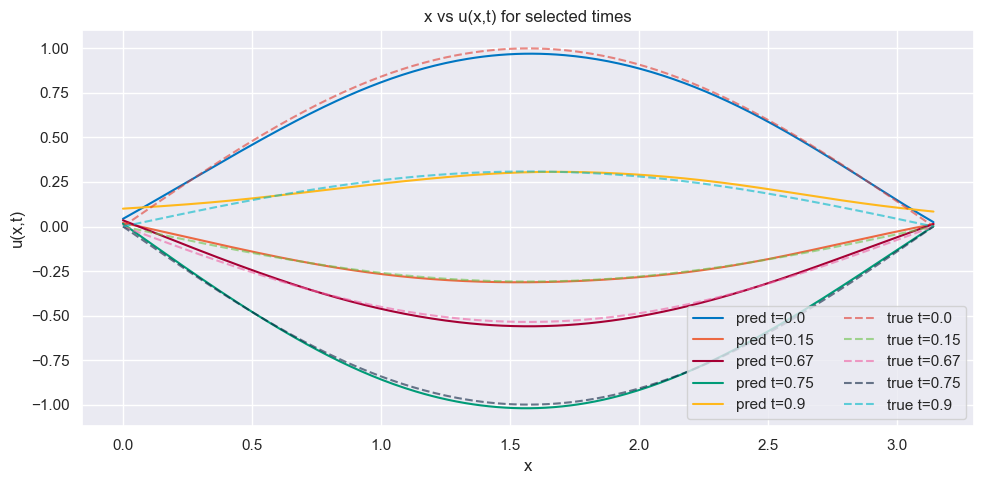

In [18]:
# Plot x vs u(x,t) for multiple time instants using the trained model
import math
import torch
import matplotlib.pyplot as plt

def plot_x_vs_u_at_times(model, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=200, L_val=None, with_exact=True):
    L_local = float(L_val if L_val is not None else L)
    x = torch.linspace(0.0, L_local, Nx).view(-1, 1).to(device)
    curves = []
    with torch.no_grad():
        for t_val in times:
            t = torch.full_like(x, float(t_val)).to(device)
            x_norm = x_normalizer.normalize(x)
            t_norm = t_normalizer.normalize(t)
            u_pred_output_norm = model(torch.cat([x_norm, t_norm], dim=1))
            u_pred_output_denorm = u_normalizer.denormalize(u_pred_output_norm)
            curves.append((t_val, x.squeeze().cpu(), u_pred_output_denorm.squeeze().cpu()))

    plt.figure(figsize=(10,5))
    for t_val, x_cpu, u_cpu in curves:
        plt.plot(x_cpu.numpy(), u_cpu.numpy(), label=f"pred t={t_val}")

    # Optional exact solution overlay if u(x,t) is defined above
    if with_exact and 'u' in globals():
        for t_val in times:
            x_t = torch.linspace(0.0, L_local, Nx).view(-1,1).to(device)
            t_t = torch.full_like(x_t, float(t_val)).to(device)
            u_true = u_exact(x_t, t_t).detach().cpu().squeeze()
            plt.plot(x_t.squeeze().cpu().numpy(), u_true.numpy(), '--', alpha=0.6, label=f"true t={t_val}")

    plt.xlabel('x')
    plt.ylabel('u(x,t)')
    plt.title('x vs u(x,t) for selected times')
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

# Run the plot for default times
plot_x_vs_u_at_times(pinn, times=(0.0, 0.15, 0.67, 0.75, 0.9), Nx=300, L_val=L, with_exact=True)

In [19]:
Nx, Nt = 200, 200
xv = np.linspace(0, np.pi, Nx)
tv = np.linspace(0, 1, Nt)
X, T = np.meshgrid(xv, tv, indexing="ij")          # X,T shape: (Nx, Nt)

xg = torch.tensor(X.reshape(-1, 1), dtype=torch.float32, device=device)
tg = torch.tensor(T.reshape(-1, 1), dtype=torch.float32, device=device)

xg_n = x_normalizer.normalize(xg)
tg_n = t_normalizer.normalize(tg)

with torch.no_grad():
    u_n = pinn(torch.cat([xg_n, tg_n], dim=1))

u_pred = u_normalizer.denormalize(u_n).cpu().numpy().reshape(Nx, Nt)
u_true = u_exact(xg, tg).cpu().numpy().reshape(Nx, Nt)
R_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true) * 100

print(f"Grid relative error (u):     {R_u:.6f}%")

Grid relative error (u):     4.900534%
